# A Simple Language Model (OPTIONAL)

```yaml
Course:  DS 5001
Module:  03 Lab
Topic:   A Simple Language Model
Author:  R.C. Alvarado
Date:    12 December 2023
```

## Purpose 

We now create a simple unigram langage model from a set of novels and use it to predict some sample sentences.

We don't worry about missing words but instead use a simple smoothing hack. 

This is just to demonstrate how we convert the counts from a token table into a language model, and how to use the model to predict sentences.

We also demonstrate how to compute the perplexity of our results.

## Set Up

### Import libraries

In [1]:
import pandas as pd
import numpy as np

### Configure

In [2]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
output_dir = config['DEFAULT']['output_dir']

In [3]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
path_prefix = f"{output_dir}/austen-combo"

## Get Data

We grab our corpus of two novels.

In [4]:
VOCAB = pd.read_csv(f"{path_prefix}-VOCAB.csv").set_index('term_str')
TOKEN = pd.read_csv(f"{path_prefix}-TOKENS.csv").set_index(OHCO)

In [5]:
VOCAB

,n
term_str,
1,3
15,1
16,1
1760,1
1784,1
...,...
youthful,3
z,1
zeal,7


## Create Unigram Model

Our vocabulary already is a language model -- it contains information for the distribution of each word. Each word is an event in the sample space.

### Extract probability features ($p$, $i$, and $h$)

We use $i$ to stand for the inverse log probability of $x$, following our intuition that it represents information as "surprisal".

$ i(x) = log_2(\frac{1}{p(x)}) $

$i$ is the inverse of log probability, the second term in the entropy formula $ H(x) = \sum_x p(x) log_2(\frac{1}{p(x)}) $

In [6]:
n_tokens = VOCAB.n.sum()
n_terms = VOCAB.n.count() # same as vocab.shape[0]

In [7]:
VOCAB['p'] = VOCAB['n'] / n_tokens
VOCAB['p2'] = VOCAB['n'] / n_terms # Some sources say to do this
VOCAB['i'] = np.log2(1/VOCAB['p'])
VOCAB['h'] = VOCAB['p'] * VOCAB['i']

In [8]:
VOCAB.sort_values('p', ascending=False)

,n,p,p2,i,h
term_str,,,,,
the,7435,0.036303,0.902525,4.783753,0.173666
to,6923,0.033803,0.840374,4.886689,0.165187
and,6290,0.030713,0.763535,5.025026,0.154332
of,6146,0.030009,0.746055,5.058438,0.151801
her,3747,0.018296,0.454843,5.772350,0.105609
...,...,...,...,...,...
reservedness,1,0.000005,0.000121,17.643870,0.000086
reserving,1,0.000005,0.000121,17.643870,0.000086
enthusiast,1,0.000005,0.000121,17.643870,0.000086


### Compute entropy $H$ of the model

In [9]:
H = VOCAB.h.sum()

In [10]:
H

9.149865771066672

### Compute redundancy $R$

In [11]:
Hmax = np.log2(n_terms)
R = 1 - (H/Hmax)

In [12]:
R

0.29660127483380216

So, the redundancy of Austen's English from these two novels $R_{austen}$ is about $30\%$. Shannon estimated the redundancy of English $R_{english}$ to be $54\%$ (see Shannon 1953 in the Readings).

## Predict Senteces

In other words, estimate the probability of a sentence for a given language model.

We first define some sentences, all of a given length.

We hold length constant because probability estimates are sensitive to sentence length. 

In [13]:
test_sentences = """
I love you
I love cars
I want to
Anne said to
said to her
he said to
she said to
said to him
she read the
she went to
robots fly ufos
""".split('\n')[1:-1]

In [14]:
TEST_SENT = pd.DataFrame({'sent_str':test_sentences})
TEST_SENT.index.name = 'sent_id'

In [15]:
TEST_SENT

,sent_str
sent_id,
0,I love you
1,I love cars
2,I want to
3,Anne said to
4,said to her
5,he said to
6,she said to
7,said to him
8,she read the


In [16]:
TEST_TOKEN = TEST_SENT.sent_str.str.split(expand=True).stack().to_frame('token_str')
TEST_TOKEN.index.names = ['sent_id', 'token_num']
TEST_TOKEN['term_str'] = TEST_TOKEN.token_str.str.replace(r'[\W_]+', '').str.lower()

In [17]:
TEST_TOKEN

token_str term_str
sent_id token_num                   
0       0                 I        i
        1              love     love
        2               you      you
1       0                 I        i
        1              love     love
        2              cars     cars
2       0                 I        i
        1              want     want
        2                to       to
3       0              Anne     anne
        1              said     said
        2                to       to
4       0              said     said
        1                to       to
        2               her      her
5       0                he       he
        1              said     said
        2                to       to
6       0               she      she
        1              said     said
        2                to       to
7       0              said     said
        1                to       to
        2               him      him
8       0               she      she
        1              read     read
        2               the      the
9       0               she      she
        1              went     went
        2                to       to
10      0            robots   robots
        1               fly      fly
        2              ufos     ufos

We apply the model by joining it to the test data.

In [18]:
TEST_TOKEN = TEST_TOKEN.join(VOCAB.p, on='term_str').fillna(VOCAB.p.min())

In [19]:
TEST_TOKEN.head()

token_str term_str         p
sent_id token_num                             
0       0                 I        i  0.015273
        1              love     love  0.000581
        2               you      you  0.008882
1       0                 I        i  0.015273
        1              love     love  0.000581

We get log probabilities to avoid underflow.

In [20]:
TEST_TOKEN['logp'] = np.log2(TEST_TOKEN.p)

In [21]:
TEST_SENT['logp_sum'] = TEST_TOKEN.groupby('sent_id').logp.sum()

In [22]:
TEST_SENT.sort_values('logp_sum', ascending=False).style.background_gradient()

,sent_str,logp_sum
sent_id,,
4,said to her,-19.148091
6,she said to,-19.589681
5,he said to,-20.000020
7,said to him,-20.904567
3,Anne said to,-22.045197
2,I want to,-22.353951
9,she went to,-22.440719
8,she read the,-23.512281
0,I love you,-23.596838


Note the log probability is just the negative of information, which we already computed in our model.

So, going forward we can just do the following.

Note we also compute mean $i$; we will use this below.

Mean and sum of $i$ will be linearly related in this example because sentence length is constant.

In [23]:
TEST_TOKEN = TEST_TOKEN.join(VOCAB.i, on='term_str').fillna(VOCAB.i.max())
TEST_SENT['i_sum'] = TEST_TOKEN.groupby('sent_id').i.sum()
TEST_SENT['i_mean'] = TEST_TOKEN.groupby('sent_id').i.mean()

In [24]:
TEST_SENT.sort_values('i_sum').style.background_gradient(axis=None)

,sent_str,logp_sum,i_sum,i_mean
sent_id,,,,
4,said to her,-19.148091,19.148091,6.382697
6,she said to,-19.589681,19.589681,6.529894
5,he said to,-20.000020,20.000020,6.666673
7,said to him,-20.904567,20.904567,6.968189
3,Anne said to,-22.045197,22.045197,7.348399
2,I want to,-22.353951,22.353951,7.451317
9,she went to,-22.440719,22.440719,7.480240
8,she read the,-23.512281,23.512281,7.837427
0,I love you,-23.596838,23.596838,7.865613


## Perplexity

Perplexity is a measure of the performance of the model.

Instead of using mean log probability as in the example above, we can just use mean of $i$.

In [25]:
TEST_SENT['pp'] = np.exp2(TEST_SENT.i_mean)

In [26]:
TEST_SENT.sort_values('pp').style.background_gradient()

,sent_str,logp_sum,i_sum,i_mean,pp
sent_id,,,,,
4,said to her,-19.148091,19.148091,6.382697,83.441717
6,she said to,-19.589681,19.589681,6.529894,92.404665
5,he said to,-20.000020,20.000020,6.666673,101.594145
7,said to him,-20.904567,20.904567,6.968189,125.208539
3,Anne said to,-22.045197,22.045197,7.348399,162.962797
2,I want to,-22.353951,22.353951,7.451317,175.012846
9,she went to,-22.440719,22.440719,7.480240,178.556838
8,she read the,-23.512281,23.512281,7.837427,228.718145
0,I love you,-23.596838,23.596838,7.865613,233.230526


If we have lots of high perplexity sentences relative to the performance of another model, then our model is not so good ...

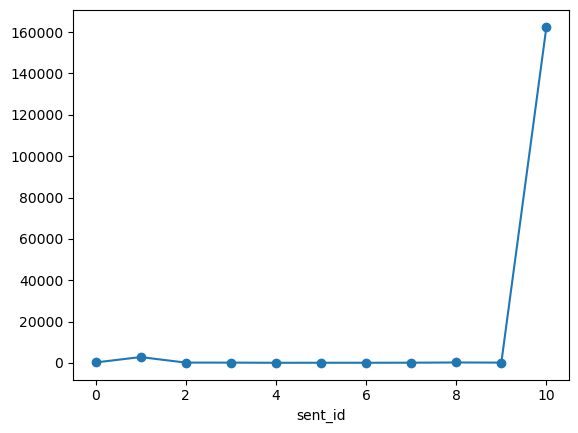

In [27]:
TEST_SENT.pp.plot(style='o-');